In [1]:
import os
import tensorflow as tf
import numpy as np
import time
from datetime import timedelta
import math
from sklearn.metrics import confusion_matrix
from mlp.data_providers import CIFAR10DataProvider, CIFAR100DataProvider
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [2]:
train_data = CIFAR10DataProvider('train', batch_size=50)
valid_data = CIFAR10DataProvider('valid', batch_size=50)

In [3]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    images = images.reshape(9, 3, 32, 32).transpose(0,2,3,1).astype("float")
    cls_true = np.array(cls_true)
    fig, axes1 = plt.subplots(5,5,figsize=(3,3))
    for j in range(5):
        for k in range(5):
            i = np.random.choice(range(len(images)))
            axes1[j][k].set_axis_off()
            axes1[j][k].imshow(images[i:i+1][0])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.

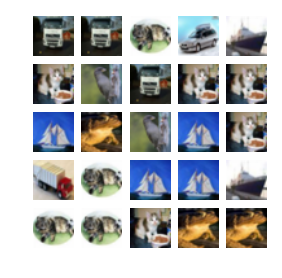

In [4]:
i=0
data=[]
cls=[]
for input_batch, target_batch in train_data:
    data.append(input_batch)
    cls.append(target_batch)
    i+=1
    if i>=9:
        break
# Get the first images from the test-set.
images = data[0][0:9]

# Get the true classes for those images.
cls_true = cls[0][0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

In [5]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [6]:
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights

In [7]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

In [8]:
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

In [9]:
# Convolutional Layer 1.
filter_size1 = 5          # Convolution filters are 5 x 5 pixels.
num_filters1 = 16         # There are 16 of these filters.

#Change number of filters

#num_filters1 = 32 
#num_filters1 = 72
#num_filters1 = 142

# Fully-connected layer.
fc_size = 128           

In [10]:
# We know that CIFAR-10 images are 32 pixels in each dimension.
img_size = 32

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# Number of colour channels for the images: 3 channels.
num_channels = 3

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size * img_size * num_channels


# Number of classes, one class for each of 10 digits.
num_classes = 10

In [11]:
#Inputs
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
#Changing shape of inputs to 4d tensor
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])
#Trget data
y_true = tf.placeholder(tf.float32, shape=[None, 10], name='y_true')
#True answer
y_true_cls = tf.argmax(y_true, dimension=1)


In [15]:
#The first convolutional layer
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)

In [16]:
#Flattened the convolutional layer to pass it to output layer
layer_flat, num_features = flatten_layer(layer_conv1)

In [17]:
#Output layer is to produce 10 output corresponding to the number of obj classes 
layer_fc2 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=num_classes,
                         use_relu=False)

In [18]:
#Computing softmax-probability ditribution 
y_pred = tf.nn.softmax(layer_fc2)
#Finding the most probably object
y_pred_cls = tf.argmax(y_pred, dimension=1)
#Computng softmax-cross-entropy
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,labels=y_true)
#Reducing cross-entropy error to do back-propagation
cost = tf.reduce_mean(cross_entropy)
#Training with adam optimizer with learning rate .0001 by minimizing cost(cross-entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)
#Comparing the most probably word obj with the correct answer 
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
#Computing accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [27]:
epochs=60
init = tf.global_variables_initializer()
inputs = tf.placeholder(tf.float32, [None, train_data.inputs.shape[1]], 'inputs')
targets = tf.placeholder(tf.float32, [None, train_data.num_classes], 'targets')
with tf.Session() as sess:
    sess.run(init)
    for e in range(epochs):
        running_error = 0.
        running_accuracy = 0.
        for input_batch, target_batch in train_data:
            #print(len(target_batch))
            _, batch_error, batch_acc = sess.run([optimizer, cost, accuracy], feed_dict={x: input_batch, y_true: target_batch})
            running_error += batch_error
            running_accuracy += batch_acc
        running_error /= train_data.num_batches
        running_accuracy /= train_data.num_batches
        print('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f}'
              .format(e + 1, running_error, running_accuracy))
        with open("sep1_1_1_{0}.txt".format(num_filters1), "a") as myfile:
            myfile.write('End of epoch {0:02d}: err(train)={1:.2f} acc(train)={2:.2f}\n'.format(e + 1, running_error, running_accuracy))
        if (e + 1) % 5 == 0:
            valid_error = 0.
            valid_accuracy = 0.
            for input_batch, target_batch in valid_data:
                batch_error, batch_acc = sess.run(
                    [cost, accuracy], 
                    feed_dict={x: input_batch, y_true: target_batch})
                valid_error += batch_error
                valid_accuracy += batch_acc
            valid_error /= valid_data.num_batches
            valid_accuracy /= valid_data.num_batches
            print('                 err(valid)={0:.2f} acc(valid)={1:.2f}'
                   .format(valid_error, valid_accuracy))
            with open("sep1_1_1_{0}.txt".format(num_filters1), "a") as myfile:
                myfile.write('                 err(valid)={0:.2f} acc(valid)={1:.2f}\n'.format(valid_error, valid_accuracy))
            
            
        

End of epoch 01: err(train)=1.89 acc(train)=0.27
End of epoch 02: err(train)=1.76 acc(train)=0.39
End of epoch 03: err(train)=1.64 acc(train)=0.43
End of epoch 04: err(train)=1.57 acc(train)=0.46
End of epoch 05: err(train)=1.53 acc(train)=0.47
                 err(valid)=1.53 acc(valid)=0.47
End of epoch 06: err(train)=1.50 acc(train)=0.48
End of epoch 07: err(train)=1.47 acc(train)=0.49
End of epoch 08: err(train)=1.45 acc(train)=0.50
End of epoch 09: err(train)=1.43 acc(train)=0.50
End of epoch 10: err(train)=1.42 acc(train)=0.51
                 err(valid)=1.45 acc(valid)=0.50
End of epoch 11: err(train)=1.40 acc(train)=0.52
End of epoch 12: err(train)=1.39 acc(train)=0.52
End of epoch 13: err(train)=1.38 acc(train)=0.53
End of epoch 14: err(train)=1.36 acc(train)=0.53
End of epoch 15: err(train)=1.35 acc(train)=0.53
                 err(valid)=1.39 acc(valid)=0.52
End of epoch 16: err(train)=1.34 acc(train)=0.54
End of epoch 17: err(train)=1.33 acc(train)=0.54
End of epoch 18: err